# Denoising Diffusion Probabilistic Models with miniai

## Installing MiniAi and some other libraries

In [2]:
!git clone https://github.com/fastai/course22p2.git

Cloning into 'course22p2'...
remote: Enumerating objects: 1176, done.
remote: Counting objects: 100% (381/381), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 1176 (delta 319), reused 294 (delta 294), pack-reused 795 (from 1)
Receiving objects: 100% (1176/1176), 98.57 MiB | 35.86 MiB/s, done.
Resolving deltas: 100% (714/714), done.


In [3]:
%cd course22p2/

/content/course22p2


In [4]:
!pip install -e .

Obtaining file:///content/course22p2
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 

In [5]:
!pip install \
    fsspec==2023.9.0 \
    numpy==1.26.4 \
    torchaudio==2.0.2 \
    diffusers==0.24.0 \
    huggingface_hub==0.22.2 \
    transformers==4.38.2 \
    accelerate==0.27.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 117.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 88.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: fsspec
    Found existing installat

## Imports

In [2]:
import os


In [1]:
!nvidia-smi                 # should list a Tesla T4
import torch
print("Torch:", torch.__version__)
print("Built with CUDA:", torch.version.cuda)
print("CUDA available  :", torch.cuda.is_available())

Mon Aug  4 18:03:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             43W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.diffusion import *
from types import SimpleNamespace

## Loading in the dataset

In [13]:
from pathlib import Path
import zipfile, os, re

zip_path   = Path('/content/data/preprocessed_128.zip')
out_dir1    = Path('/content/data/preprocessed2/facade')   # keep façade files here
out_dir2    = Path('/content/data/preprocessed2/nadir')   # keep nadir files here

out_dir1.mkdir(parents=True, exist_ok=True)
out_dir2.mkdir(parents=True, exist_ok=True)


# extract only files that end with "_facade.<ext>"
pattern1 = re.compile(r'.*_facade\.(png|jpg|jpeg)$', re.IGNORECASE)
pattern2 = re.compile(r'.*_nadir\.(png|jpg|jpeg)$', re.IGNORECASE)


with zipfile.ZipFile(zip_path) as z:
    for member in z.infolist():
        if pattern1.match(member.filename):
             z.extract(member, out_dir1)
        elif pattern2.match(member.filename):
             z.extract(member, out_dir2)


print(f"Extracted {len(list(out_dir1.rglob('*')))} façade images → {out_dir1}")
print(f"Extracted {len(list(out_dir2.rglob('*')))} nadir images → {out_dir2}")



Extracted 11444 façade images → /content/data/preprocessed2/facade
Extracted 11441 nadir images → /content/data/preprocessed2/nadir


In [14]:
out_dir1    = Path('/content/data/preprocessed2/facade/preprocessed_128')   # keep façade files here
out_dir2    = Path('/content/data/preprocessed2/nadir/preprocessed_128')

In [15]:
import pandas as pd
df = pd.read_csv('/content/tree_metadata_dev.csv')
print(f"Loaded metadata for {len(df)} trees from CSV.")

Loaded metadata for 17707 trees from CSV.


In [16]:
def generate_examples():
    """
    Generator function that iterates through the CSV, constructs filenames,
    and yields examples if the corresponding images exist.
    """
    for _, row in df.iterrows():
        tree_id_int = row['treeID']
        image_id_str = f"{tree_id_int:05d}"
        facade_path = out_dir1 / f"{image_id_str}_facade.png"
        nadir_path = out_dir2 / f"{image_id_str}_nadir.png"

        if facade_path.exists() and nadir_path.exists():
            yield {
                'id': image_id_str,
                'facade_image': str(facade_path),
                'nadir_image': str(nadir_path),
                'species': row['species'],
                'tree_height': row['tree_H']
            }

In [17]:
from datasets import Image, Features, Value, Dataset, DatasetDict

In [18]:
features = Features({
    'id': Value('string'),
    'facade_image': Image(),
    'nadir_image': Image(),
    'species': Value('string'),
    'tree_height': Value('float32')
})


In [19]:
full_dataset = Dataset.from_generator(
    generate_examples,
    features=features,
)

Generating train split: 0 examples [00:00, ? examples/s]

In [20]:
print("\nFull dataset created successfully:")
print(full_dataset)


Full dataset created successfully:
Dataset({
    features: ['id', 'facade_image', 'nadir_image', 'species', 'tree_height'],
    num_rows: 11440
})


In [21]:
dsd = full_dataset.train_test_split(test_size=0.05, seed=42)
dsd['valid'] = dsd.pop('test')


In [22]:
dsd

DatasetDict({
    train: Dataset({
        features: ['id', 'facade_image', 'nadir_image', 'species', 'tree_height'],
        num_rows: 10868
    })
    valid: Dataset({
        features: ['id', 'facade_image', 'nadir_image', 'species', 'tree_height'],
        num_rows: 572
    })
})

In [23]:
dsd['train'][0]

{'id': '19535',
 'facade_image': <PIL.PngImagePlugin.PngImageFile image mode=L size=128x128>,
 'nadir_image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=128x128>,
 'species': 'Picea_abies',
 'tree_height': 3.5140380859375}

In [24]:



unique_species = dsd['train'].unique('species')

species_to_idx = {species: i for i, species in enumerate(unique_species)}
num_species = len(unique_species)

print(f"Found {num_species} unique species.")
print("Species to ID mapping:", species_to_idx)

Flattening the indices:   0%|          | 0/10868 [00:00<?, ? examples/s]

Found 30 unique species.
Species to ID mapping: {'Picea_abies': 0, 'Tilia_cordata': 1, 'Pinus_sylvestris': 2, 'Quercus_robur': 3, 'Abies_alba': 4, 'Acer_pseudoplatanus': 5, 'Carpinus_betulus': 6, 'Quercus_faginea': 7, 'Pseudotsuga_menziesii': 8, 'Pinus_resinosa': 9, 'Eucalyptus_miniata': 10, 'Pinus_nigra': 11, 'Crataegus_monogyna': 12, 'Pinus_contorta': 13, 'Fraxinus_excelsior': 14, 'Euonymus_europaeus': 15, 'Acer_campestre': 16, 'Betula_pendula': 17, 'Fagus_sylvatica': 18, 'Corylus_avellana': 19, 'Populus_tremuloides': 20, 'Fraxinus_angustifolia': 21, 'Ulmus_laevis': 22, 'Quercus_rubra': 23, 'Quercus_ilex': 24, 'Quercus_petraea': 25, 'Pinus_pinaster': 26, 'Acer_saccharum': 27, 'Populus_deltoides': 28, 'Larix_decidua': 29}


In [25]:
bs = 64

In [26]:
facade = 'facade_image'
nadir = 'nadir_image'
species = 'species'
tree_h = 'tree_height'

In [27]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [28]:
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [29]:
def abar(t, T): return (t/T*math.pi/2).cos()**2

In [30]:
def cos_sched(n_steps=1000):
    ts = torch.linspace(0, n_steps-1, n_steps)
    ab = abar(ts,n_steps)
    alp = ab/abar(ts-1,n_steps)
    return SimpleNamespace(a=alp, abar=ab, sig=(1-alp).sqrt())

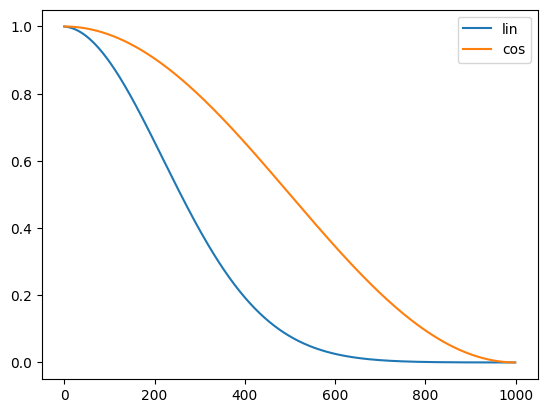

In [31]:
lin_abar = linear_sched().abar
cos_abar = cos_sched().abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

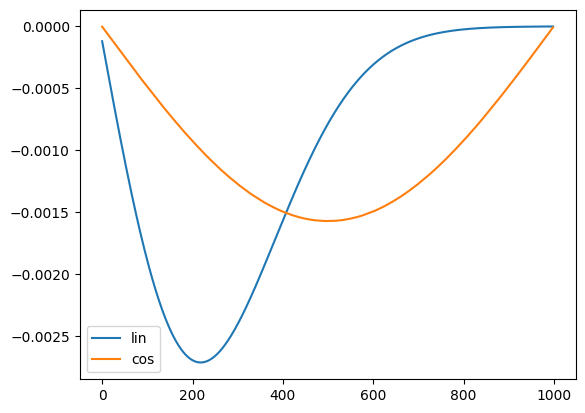

In [32]:
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

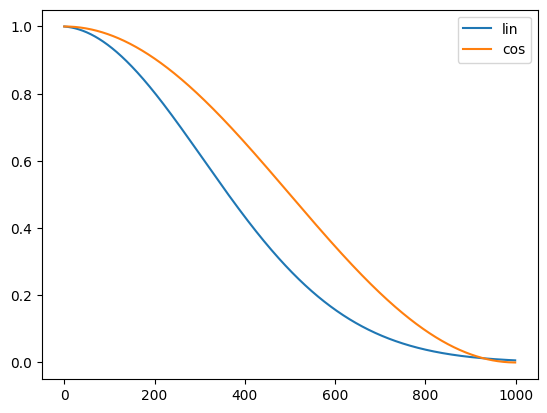

In [33]:
lin_abar = linear_sched(betamax=0.01).abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

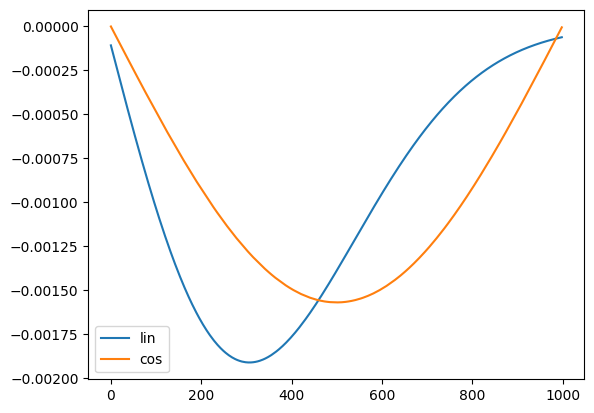

In [34]:
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

In [35]:
n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [36]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

## DataLoading

In [94]:
def collate_fn(batch):
    facade_images = torch.stack([(TF.to_tensor(sample[facade])) - 0.5 for sample in batch])
    nadir_images = torch.stack([(TF.to_tensor(sample['nadir_image'])) for sample in batch])
    tree_heights = torch.tensor([sample[tree_h] for sample in batch], dtype=torch.float).unsqueeze(1)
    label = torch.tensor([species_to_idx[sample[species]] for sample in batch], dtype=torch.long)

    return facade_images,  nadir_images, tree_heights, label

In [95]:
def make_ddpm_collate(base_collate, alphabar):
    """
    Wrap `base_collate` so the final output matches:
        ((xt, t), ε)    ← what `noisify` already returns
    """
    def _inner(batch):
        x0, nadir, tree_height, label  = base_collate(batch)          # (_ = labels we don’t need)
        (xt, t), eps = noisify(x0, alphabar)
        # ddpm_inputs is a tuple (xt, t)
        return (xt, t, nadir, tree_height, label), eps              # exactly ((xt, t), ε)
    return _inner


In [96]:
noise_collate = make_ddpm_collate(collate_fn, alphabar)

In [97]:
# def collate_ddpm(b): return noisify(default_collate(b)['image'], alphabar)
def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=noise_collate, num_workers=nw)

In [98]:
dls = DataLoaders(dl_ddpm(dsd['train']), dl_ddpm(dsd['valid']))

In [99]:
dt = dls.train
(xt, t, nadirimg, tree_height, label), eps = next(iter(dt))

In [100]:
label

tensor([ 0,  1,  0,  2,  3,  2,  2,  2,  2,  4,  2,  2,  5,  6,  7,  2,  8,  9,
        10, 11, 12,  0,  5,  2, 13, 14, 10,  7, 15,  7,  6,  2,  1, 16,  1,  6,
        17,  6, 18, 11,  2,  5, 11,  1, 19,  2, 10,  7, 18,  2,  2,  7, 10,  2,
         2, 20, 10,  5,  2,  2, 18, 12,  2,  8])

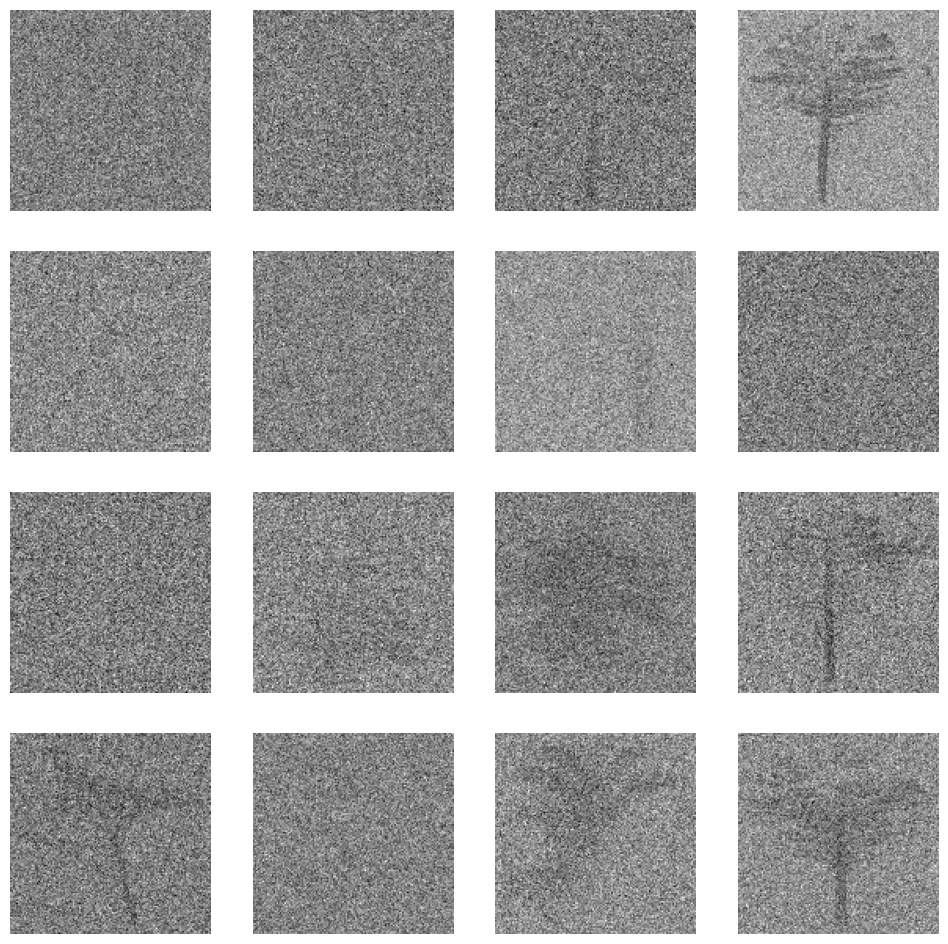

In [44]:
show_images(xt[:16])

## Training

In [39]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [88]:
class CondUNetModel(nn.Module):
    def __init__( self, n_classes,n_scalar_features=1, in_channels=1, cond_channels=3, out_channels=1, nfs=(224,448,672,896), num_layers=1):
        super().__init__()
        self.conv_in = nn.Conv2d(in_channels + cond_channels, nfs[0], kernel_size=3, padding=1)
        self.n_temb = nf = nfs[0]
        n_emb = nf*4
        self.cond_emb = nn.Embedding(n_classes, n_emb)
        self.emb_mlp = nn.Sequential(lin(self.n_temb, n_emb, norm=nn.BatchNorm1d),
                                     lin(n_emb, n_emb))
        self.downs = nn.ModuleList()
        for i in range(len(nfs)):
            ni = nf
            nf = nfs[i]
            self.downs.append(DownBlock(n_emb, ni, nf, add_down=i!=len(nfs)-1, num_layers=num_layers))
        self.mid_block = EmbResBlock(n_emb, nfs[-1])

        self.scalar_emb_mlp = nn.Sequential(
            lin(n_scalar_features, n_emb, norm=nn.BatchNorm1d),
            lin(n_emb, n_emb)
        )

        rev_nfs = list(reversed(nfs))
        nf = rev_nfs[0]
        self.ups = nn.ModuleList()
        for i in range(len(nfs)):
            prev_nf = nf
            nf = rev_nfs[i]
            ni = rev_nfs[min(i+1, len(nfs)-1)]
            self.ups.append(UpBlock(n_emb, ni, prev_nf, nf, add_up=i!=len(nfs)-1, num_layers=num_layers+1))

        self.conv_out = pre_conv(nfs[0], out_channels, act=nn.SiLU, norm=nn.BatchNorm2d, bias=False)

    def forward(self, inp):
        x, t, c_img, c_scalar = inp
        temb = timestep_embedding(t, self.n_temb)
        # cemb = self.cond_emb(c_label)
        scalar_emb = self.scalar_emb_mlp(c_scalar)
        emb = self.emb_mlp(temb) + scalar_emb
        x = torch.cat([x, c_img], dim=1)
        x = self.conv_in(x)
        saved = [x]
        for block in self.downs: x = block(x, emb)
        saved += [p for o in self.downs for p in o.saved]
        x = self.mid_block(x, emb)
        for block in self.ups: x = block(x, emb, saved)
        return self.conv_out(x)

In [49]:


lr = 5e-4
epochs = 25
lrfind = LRFinderCB()
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = CondUNetModel(30, in_channels=1, out_channels=1, nfs=(128, 256, 384, 512), num_layers=2)

learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)


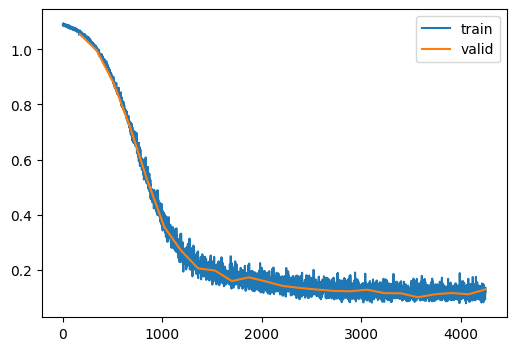

In [50]:
learn.fit(epochs)

In [95]:
import gc, torch
gc.collect(); torch.cuda.empty_cache()

In [55]:
mdl_path = Path('models')

In [56]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [57]:
# Save only the model's parameters (the state_dict)
torch.save(learn.model.state_dict(), mdl_path / 'conditional_nadironly_ddpm3543563_125_50_statedict_mae.pth')

In [104]:
model = CondUNetModel(30, in_channels=1, out_channels=1, nfs=(128, 256, 384, 512), num_layers=2)


In [105]:
# state_dict_path = mdl_path / '/content/models/conditional_nadir_ddpm3_100_statedict_mse.pth'
state_dict_path = '/content/conditional_nadir_ddpm3_125_50_statedict_mae.pth'
model.load_state_dict(torch.load(state_dict_path))
model.cuda()

CondUNetModel(
  (conv_in): Conv2d(4, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cond_emb): Embedding(30, 512)
  (emb_mlp): Sequential(
    (0): Sequential(
      (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=512, bias=True)
    )
    (1): Sequential(
      (0): SiLU()
      (1): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (downs): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0-1): 2 x EmbResBlock(
          (emb_proj): Linear(in_features=512, out_features=256, bias=True)
          (conv1): Sequential(
            (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): SiLU()
            (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (conv2): Sequential(
            (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

In [221]:
from diffusers import DDPMScheduler
from fastprogress.fastprogress import progress_bar


@torch.no_grad()
def diffusers_conditional_sample(model, sz, conditioning_tuple, sched):
    """
    Performs DDIM sampling using a Hugging Face Diffusers scheduler
    for a model that expects a TUPLE of conditions.

    Args:
        model: The trained conditional UNet model.
        sz: The shape of the output tensor (e.g., [16, 1, 32, 32]).
        conditioning_tuple (tuple): A tuple containing the conditioning tensors
                                    in the order (nadir_image, tree_height, species_id).
        sched: An initialized Diffusers scheduler (e.g., DDIMScheduler).
    """
    model.eval()

    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps.device)
    preds = []

    # Unpack the conditioning tuple and move tensors to the correct device
    c_img, c_scalar, c_label = conditioning_tuple
    c_img = c_img.to(ps.device)
    c_scalar = c_scalar.to(ps.device)
    c_label = c_label.to(ps.device)

    # The loop now iterates over the scheduler's timesteps
    for t in progress_bar(sched.timesteps):
        # Your model was trained with a batch of timesteps, so we need to expand
        # the single timestep `t` to match the batch size.
        t_batch = t.expand(sz[0]).to(ps.device)

        # 1. Predict the noise using your custom model signature
        inp = (x_t, t_batch, c_img, c_scalar, c_label)
        predicted_noise = model(inp)

        # 2. Compute the previous noisy sample x_{t-1} using the scheduler
        # The scheduler handles all the math for the DDIM step.
        scheduler_output = sched.step(predicted_noise, t, x_t)
        x_t = scheduler_output.prev_sample

        # For visualization, we can also store the predicted x0 at each step
        preds.append(scheduler_output.pred_original_sample.float().cpu())

    return preds

In [222]:
from diffusers import DDIMScheduler

In [223]:

sched = DDPMScheduler(beta_end=0.01)

# 3. SET SAMPLING STEPS
# This determines how many steps to take during inference. Fewer steps = faster.
steps = 1000
sched.set_timesteps(steps)

In [232]:
# 1. Create an iterator object from your validation dataloader
valid_iter = iter(dls.valid)

# 2. Get the first batch (this is what you were doing before)
batch1 = next(valid_iter)

# 3. Get the second batch
batch2 = next(valid_iter)
batch2 = next(valid_iter)
batch2 = next(valid_iter)



# 4. Get the third batch (this is now 2 batches ahead of the start)
batch3 = next(valid_iter)

# Now, `batch3` holds the data from the third batch of the validation set.
# You can unpack it just like you did before:
(xt, t, nadir, tree_height, label), eps = batch3
x0 = (xt - (1-alphabar[t]).sqrt().to(xt.device)[:,None,None,None]*eps) / alphabar[t].sqrt().to(xt.device)[:,None,None,None]

In [233]:
n_samples = 16
conditioning_tuple = (
    nadir[:n_samples],
    tree_height[:n_samples],
    label[:n_samples]
)

In [234]:
sz = (n_samples, 1, 128, 128)
preds = diffusers_conditional_sample(model, sz, conditioning_tuple, sched)

In [235]:
final_preds = preds[-1]

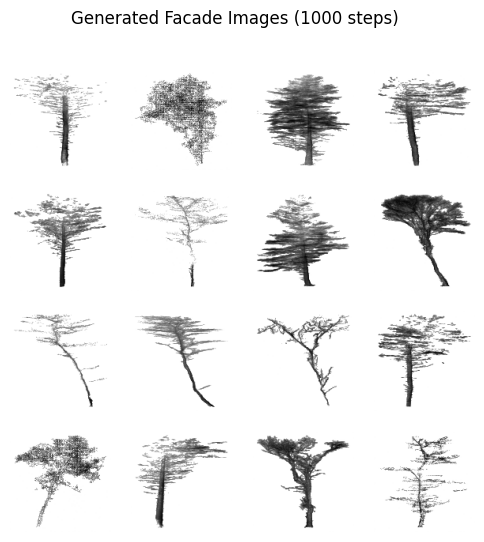

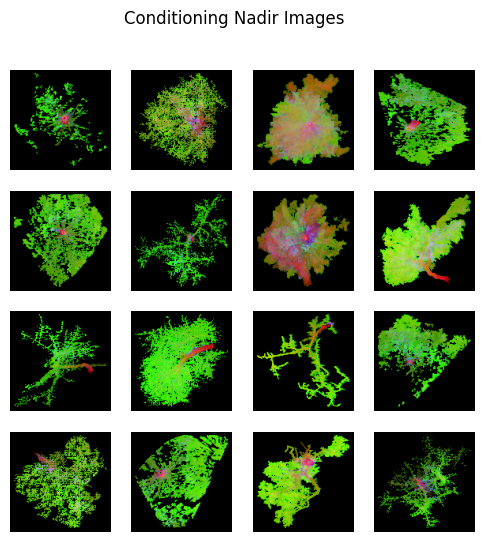

In [236]:
show_images(final_preds.clamp(-0.5, 0.5) + 0.5, imsize=1.5, suptitle=f"Generated Facade Images ({steps} steps)")

show_images(nadir[:n_samples], imsize=1.5, suptitle="Conditioning Nadir Images")

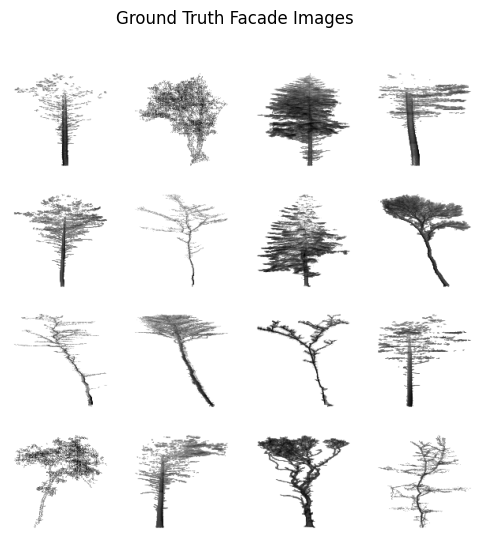

In [237]:
show_images(x0[:n_samples].clamp(-0.5, 0.5) + 0.5, imsize=1.5, suptitle="Ground Truth Facade Images")

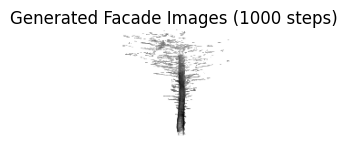

In [242]:
show_images(final_preds[0].clamp(-0.5, 0.5) + 0.5, imsize=1.5, suptitle=f"Generated Facade Images ({steps} steps)")


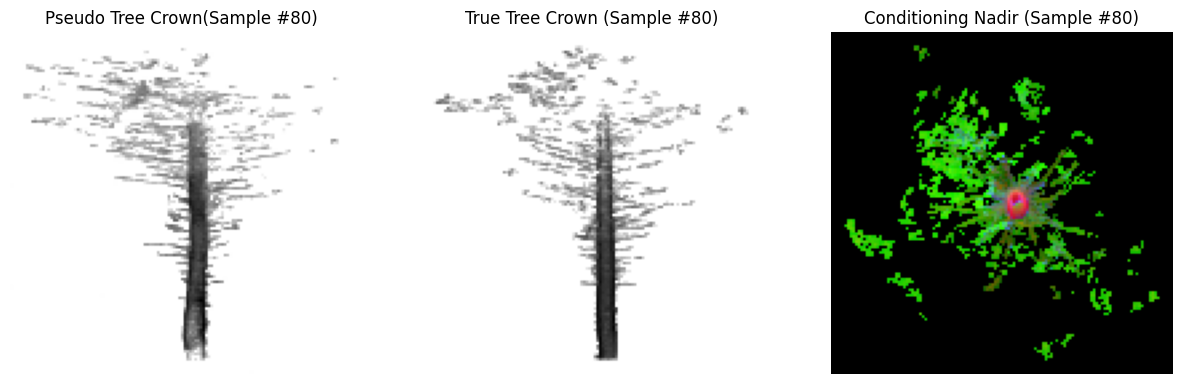

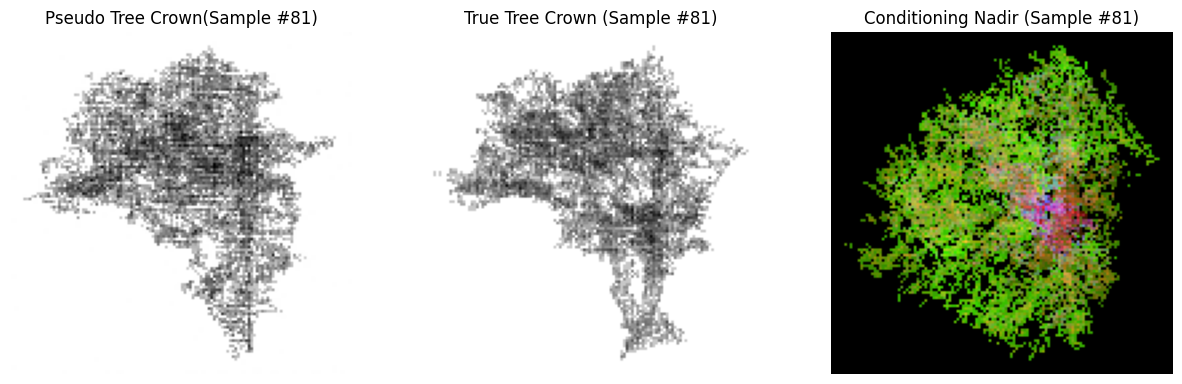

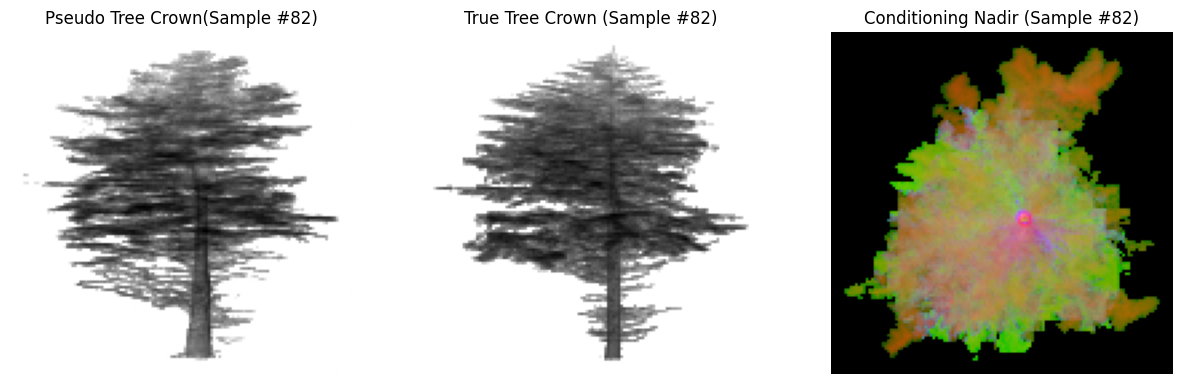

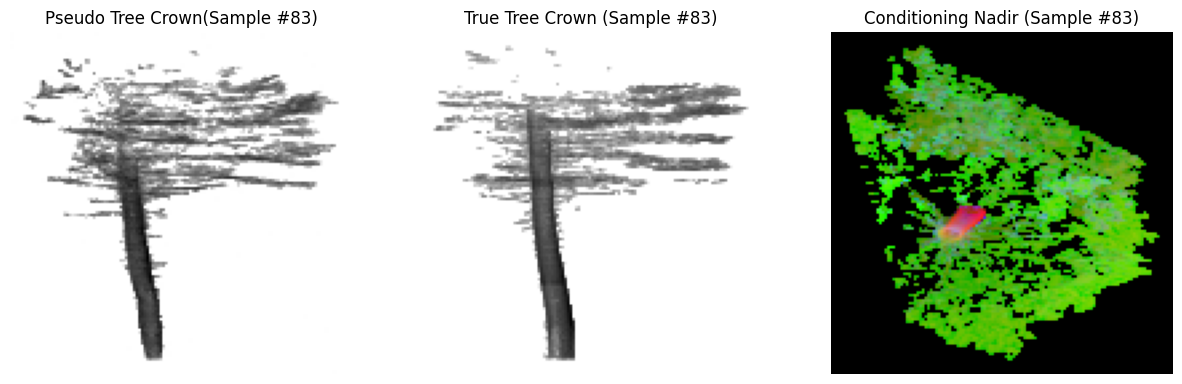

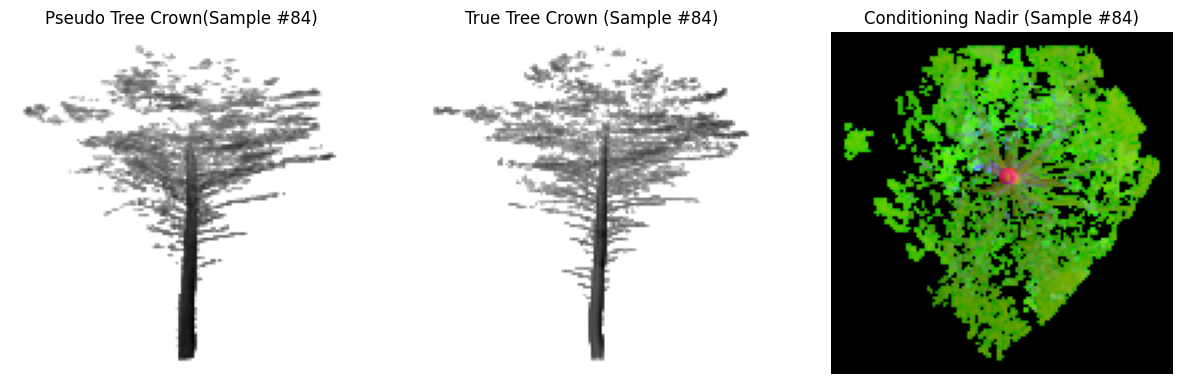

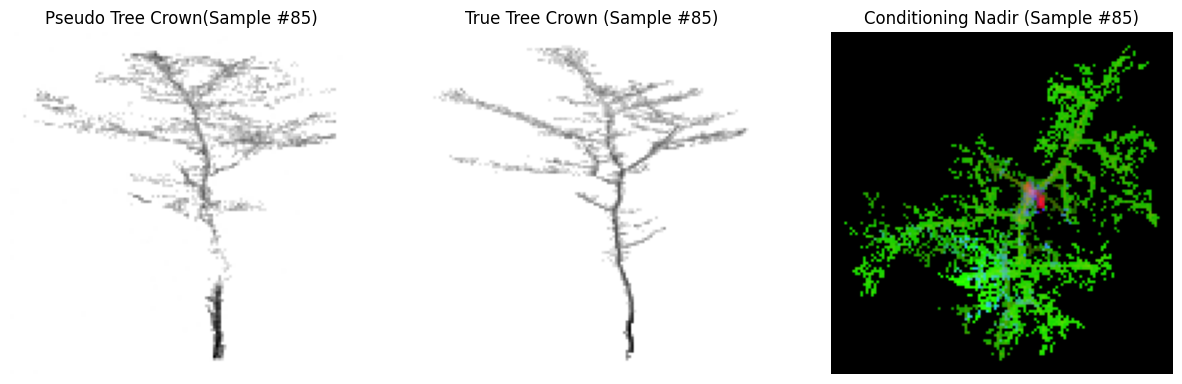

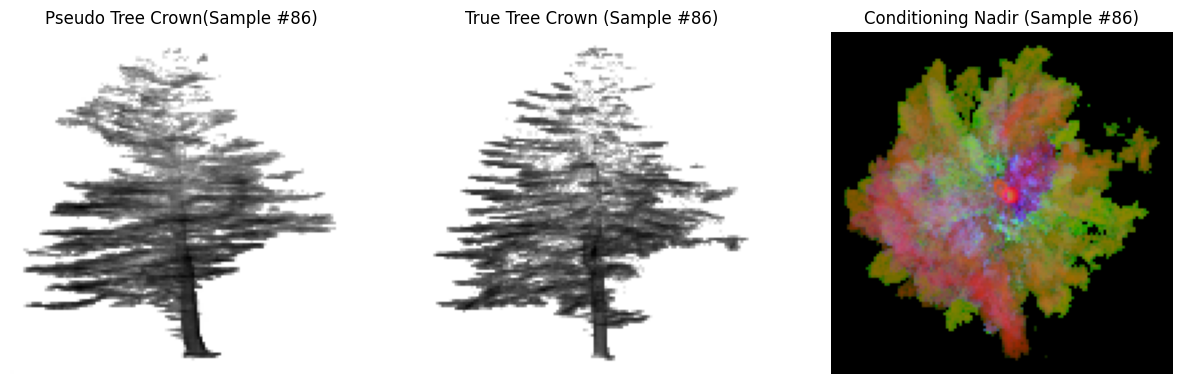

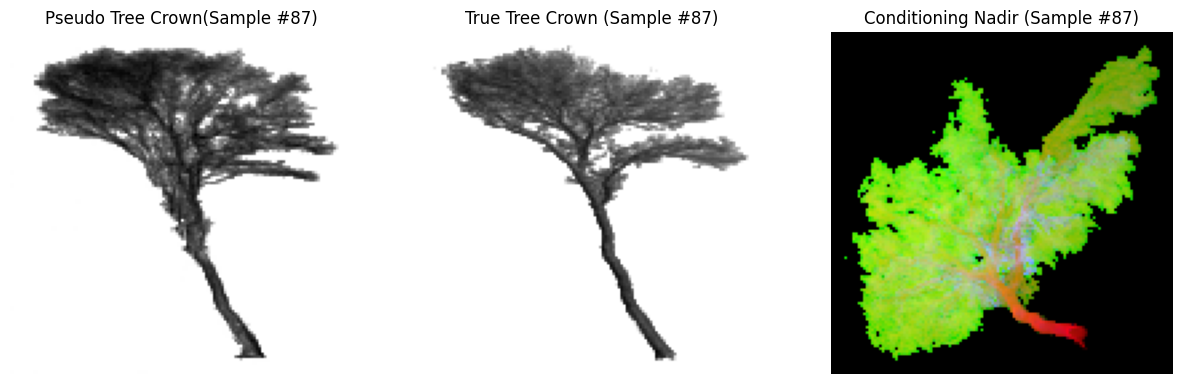

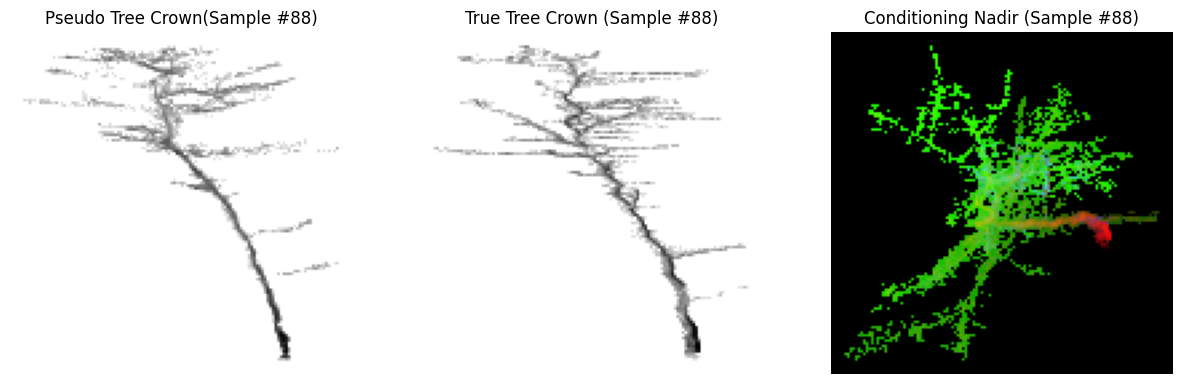

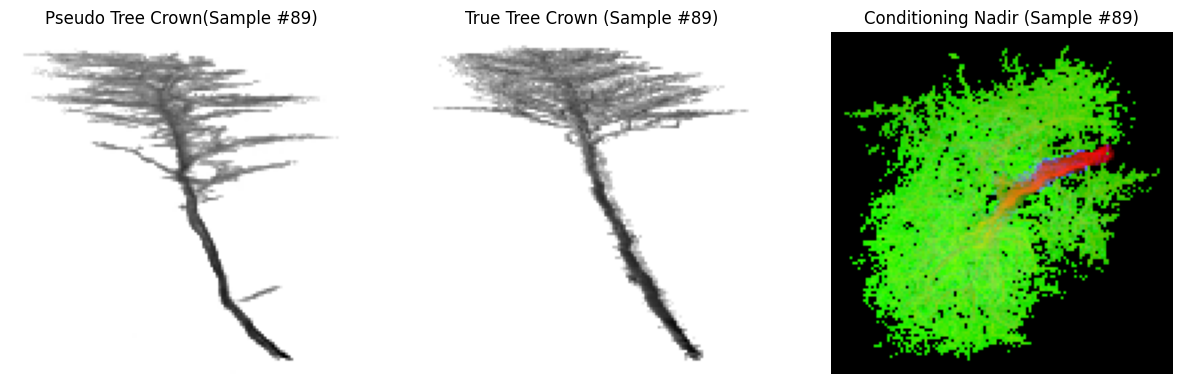

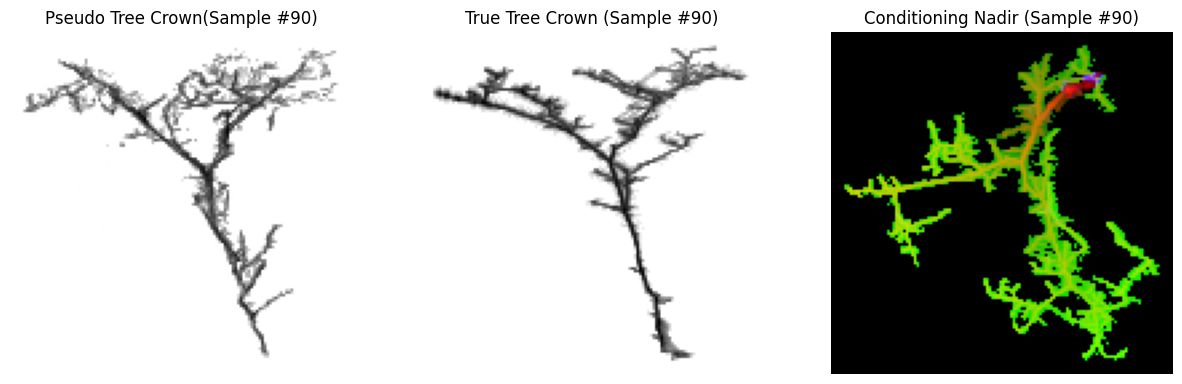

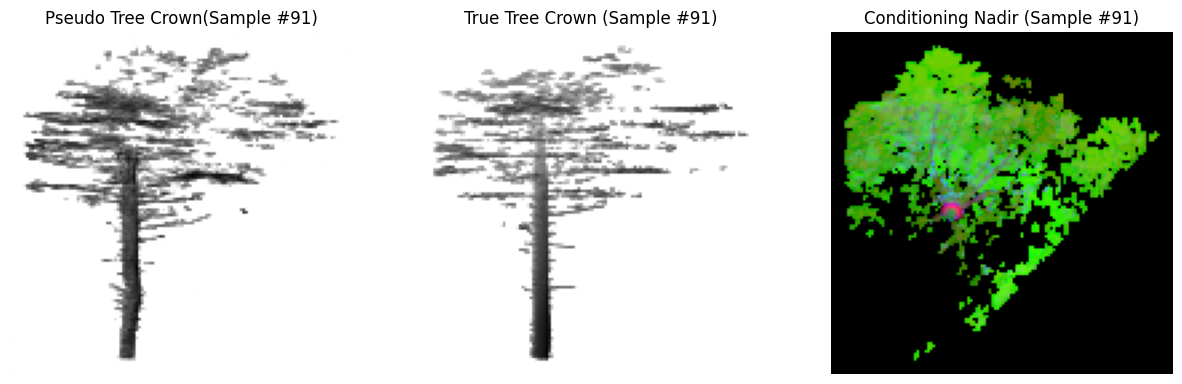

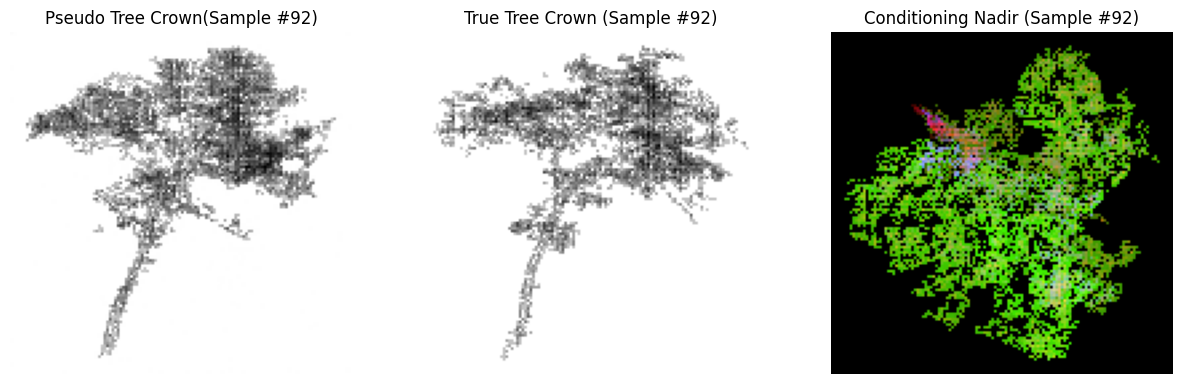

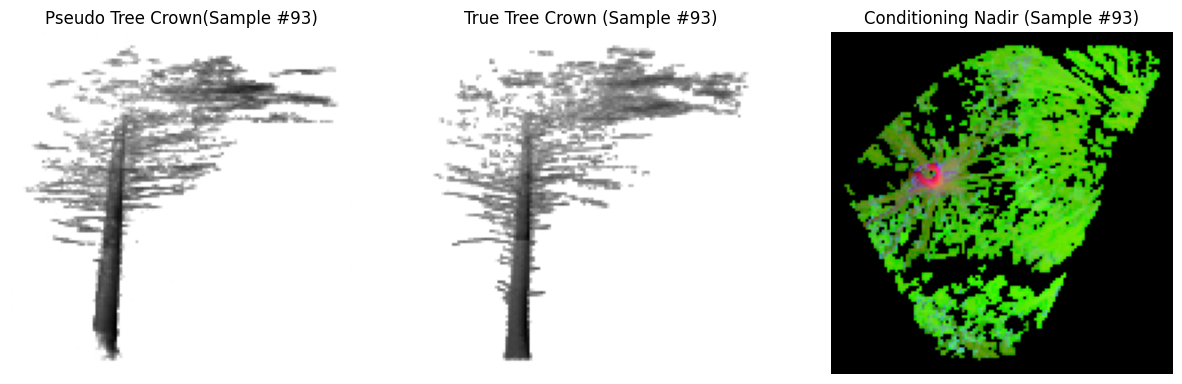

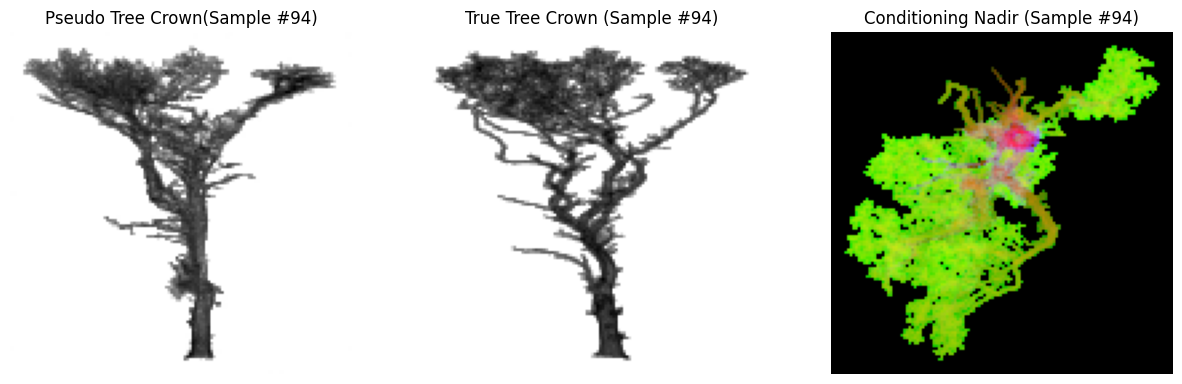

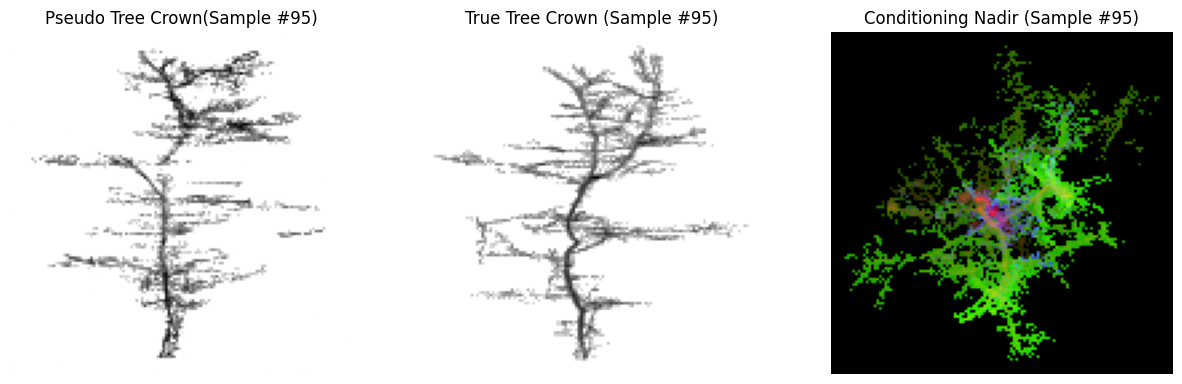

In [240]:


# --- STEP 3: Visualize using a side-by-side comparison ---
# We will use the tensors we saved in Step 1 to ensure a correct comparison.

# Choose an index from the batch to display (e.g., the 5th image, index 4)
output_dir = Path('generated_images')
output_dir.mkdir(exist_ok=True)

for idx_to_show in range(16):
  output_filename = output_dir / f"comparison_sample_{idx_to_show}.png"
  # Get the generated image for this index
  generated_image = final_preds[idx_to_show]

  # Get the ground truth image for THE EXACT SAME index from our saved batch
  ground_truth_image = x0[idx_to_show]

  # Get the conditioning nadir image for THE EXACT SAME index
  conditioning_nadir = conditioning_tuple[0][idx_to_show]

  # --- Rescale Tensors for Display ---
  display_generated = (generated_image.clamp(-0.5, 0.5) + 0.5).cpu()
  display_ground_truth = (ground_truth_image.clamp(-0.5, 0.5) + 0.5).cpu()
  display_nadir = conditioning_nadir.cpu()

  # --- Create the Plot ---
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  axes[0].imshow(display_generated.squeeze(), cmap='gray_r')
  axes[0].set_title(f"Pseudo Tree Crown(Sample #{idx_to_show + 80})")
  axes[0].axis('off')

  axes[1].imshow(display_ground_truth.squeeze(), cmap='gray_r')
  axes[1].set_title(f"True Tree Crown (Sample #{idx_to_show + 80})")
  axes[1].axis('off')

  axes[2].imshow(display_nadir.permute(1, 2, 0))
  axes[2].set_title(f"Conditioning Nadir (Sample #{idx_to_show +80})")
  axes[2].axis('off')
  plt.savefig(output_filename, dpi=300, bbox_inches='tight')
  plt.show()



In [241]:
!zip -r output.zip /content/generated_images

  adding: content/generated_images/ (stored 0%)
  adding: content/generated_images/comparison_sample_6.png (deflated 22%)
  adding: content/generated_images/comparison_sample_0.png (deflated 28%)
  adding: content/generated_images/comparison_sample_12.png (deflated 24%)
  adding: content/generated_images/comparison_sample_7.png (deflated 24%)
  adding: content/generated_images/comparison_sample_15.png (deflated 26%)
  adding: content/generated_images/comparison_sample_3.png (deflated 23%)
  adding: content/generated_images/comparison_sample_9.png (deflated 23%)
  adding: content/generated_images/comparison_sample_4.png (deflated 23%)
  adding: content/generated_images/comparison_sample_14.png (deflated 25%)
  adding: content/generated_images/comparison_sample_13.png (deflated 23%)
  adding: content/generated_images/comparison_sample_1.png (deflated 22%)
  adding: content/generated_images/comparison_sample_5.png (deflated 26%)
  adding: content/generated_images/comparison_sample_11.png 